
![](./imgs/1.png#pic_center)


### 1. 线性回归的实现
### 2. 通过特征工程扩展到多项式回归
### 3. 使用Sklearn进行房价预测

In [1]:
import numpy as np
import copy,math
import matplotlib.pyplot as plt
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; 
plt.style.use('./deeplearning.mplstyle')
from lab_utils_multi import  load_house_data, compute_cost, run_gradient_descent 
from lab_utils_multi import  norm_plot, plt_contour_multi, plt_equal_scale, plot_cost_i_w
from lab_utils_multi import zscore_normalize_features, run_gradient_descent_feng
from lab_utils_common import dlc
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
np.set_printoptions(precision=2)  # 降低numpy数组的显示精度
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


# 1. 线性回归的实现
## 1.1 数据集加载与处理
使用numpy实现一个预测房价的模型， 每个样本具有具有4个特征（大小、卧室数、楼层数和房龄）
#### 数据集：

| 大小（平方英尺） | 卧室数量 | 楼层数 | 房龄 | 价格（1000美元） |
| --------------- | ----------- | ------ | ---- | ------------------ |
| 952             | 2           | 1      | 65   | 271.5              |
| 1244            | 3           | 2      | 64   | 232                |
| 1947            | 3           | 2      | 17   | 509.8              |
| ...             | ...         | ...    | ...  | ...                |

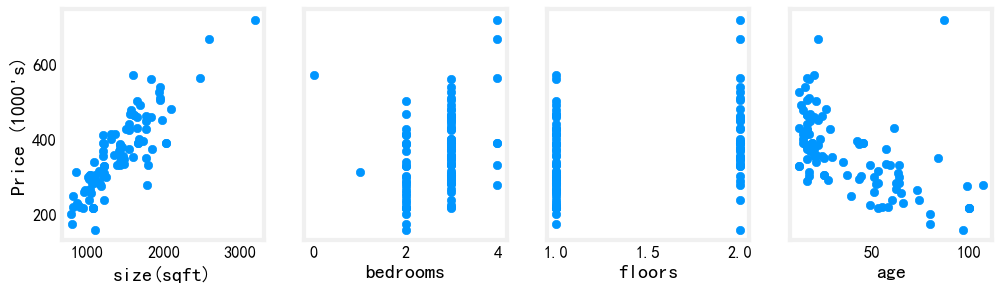

In [2]:
X_train, y_train = load_house_data()
X_features = ['size(sqft)','bedrooms','floors','age']
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

如图所示，
* 面积越大房屋的价格越高
* 房龄越小房屋价格越高
* 层高和房间数对房价没有明显影响

## 1.2 梯度下降实现
这部分主要介绍，梯度下降的数学公式，以及代码实现

### 1.2.1公式

$$
\begin{align*}
\text{重复}&\text{直到收敛:} \; \lbrace \newline\;
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{对于 j = 0..n-1}\newline \\
&b\ \ := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}
$$



其中，n 是特征的数量，参数 $w_j$ 和 $b$ 同时更新，其中

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3}
\end{align}
$$

* m 是数据集中的训练示例数量
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ 是模型的预测值，而 $y^{(i)}$ 是目标值

### 1.2.2 梯度下降实现
其中的`gradient_descent_houses`为梯度下降函数，`compute_cost`为损失函数，`compute_gradient_matrix`为梯度计算函数。

In [3]:
def run_gradient_descent(X,y,iterations=1000, alpha = 1e-6):

    m,n = X.shape
    # initialize parameters
    initial_w = np.zeros(n)
    initial_b = 0
    # run gradient descent
    w_out, b_out, hist_out = gradient_descent_houses(X ,y, initial_w, initial_b,
                                                     compute_cost, compute_gradient_matrix, alpha, iterations)
    print(f"w,b found by gradient descent: w: {w_out}, b: {b_out:0.2f}")

    return(w_out, b_out, hist_out)

### 梯度下降函数gradient_descent_houses

In [4]:
def gradient_descent_houses(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    m = len(X)
    hist={}
    hist["cost"] = []; hist["params"] = []; hist["grads"]=[]; hist["iter"]=[];
    w = copy.deepcopy(w_in)  
    b = b_in
    save_interval = np.ceil(num_iters/10000) 
    print(f"Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  ")
    print(f"---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|")
    for i in range(num_iters):
        dj_db,dj_dw = gradient_function(X, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        if i == 0 or i % save_interval == 0:
            hist["cost"].append(cost_function(X, y, w, b))
            hist["params"].append([w,b])
            hist["grads"].append([dj_dw,dj_db])
            hist["iter"].append(i)

        
        if i% math.ceil(num_iters/10) == 0:
            cst = cost_function(X, y, w, b)
            print(f"{i:9d} {cst:0.5e} {w[0]: 0.1e} {w[1]: 0.1e} {w[2]: 0.1e} {w[3]: 0.1e} {b: 0.1e} {dj_dw[0]: 0.1e} {dj_dw[1]: 0.1e} {dj_dw[2]: 0.1e} {dj_dw[3]: 0.1e} {dj_db: 0.1e}")

    return w, b, hist 

### gradient_function
计算损失函数J关于w,b的导数
$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3}
\end{align}
$$
将X转置后，X的每一行就代表某个特征的所有取值

In [5]:
def compute_gradient_matrix(X, y, w, b):
    """
    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m    
                                  
    """
    m,n = X.shape
    f_wb = X @ w + b
    e   = f_wb - y
    dj_dw  = (1/m) * (X.T @ e)
    dj_db  = (1/m) * np.sum(e)

    return dj_db,dj_dw

## 1.3 特征缩放
通过前面的函数，已经能通过数据集通过梯度下降找到比较合适的w,b，显然alpha并不为常量。
尝试不同的alpha，我们来看看结果

### $\alpha$ = 9e-7

In [6]:
_, _, hist = run_gradient_descent(X_train, y_train, 10, alpha = 9.9e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 9.55884e+04  5.5e-01  1.0e-03  5.1e-04  1.2e-02  3.6e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 1.28213e+05 -8.8e-02 -1.7e-04 -1.0e-04 -3.4e-03 -4.8e-05  6.4e+05  1.2e+03  6.2e+02  1.6e+04  4.1e+02
        2 1.72159e+05  6.5e-01  1.2e-03  5.9e-04  1.3e-02  4.3e-04 -7.4e+05 -1.4e+03 -7.0e+02 -1.7e+04 -4.9e+02
        3 2.31358e+05 -2.1e-01 -4.0e-04 -2.3e-04 -7.5e-03 -1.2e-04  8.6e+05  1.6e+03  8.3e+02  2.1e+04  5.6e+02
        4 3.11100e+05  7.9e-01  1.4e-03  7.1e-04  1.5e-02  5.3e-04 -1.0e+06 -1.8e+03 -9.5e+02 -2.3e+04 -6.6e+02
        5 4.18517e+05 -3.7e-01 -7.1e-04 -4.0e-04 -1.3e-02 -2.1e-04  1.2e+06  2.1e+03  1.1e+03  2.8e+04  7.5e+02
        6 5.63212e+05  9.7e-01  1.7e-03  8.7e-04  1.8e-02  6.6e-04 -1.3e+06 -2.5e+03 -1.3e+03 -3.1e+04 -

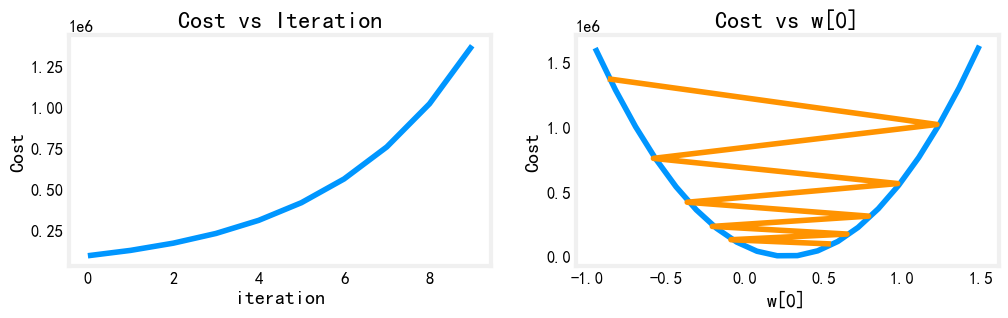

In [7]:
plot_cost_i_w(X_train, y_train, hist)

Cost函数不收敛，显然$\alpha$过于大了。
为了方便演示，右侧的图表仅展示特征$x[0]$的参数$w_0$

### $\alpha$ = 9e-7


In [8]:
_, _, hist = run_gradient_descent(X_train, y_train, 10, alpha = 9e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 6.64616e+04  5.0e-01  9.1e-04  4.7e-04  1.1e-02  3.3e-04 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 6.18990e+04  1.8e-02  2.1e-05  2.0e-06 -7.9e-04  1.9e-05  5.3e+05  9.8e+02  5.2e+02  1.3e+04  3.4e+02
        2 5.76572e+04  4.8e-01  8.6e-04  4.4e-04  9.5e-03  3.2e-04 -5.1e+05 -9.3e+02 -4.8e+02 -1.1e+04 -3.4e+02
        3 5.37137e+04  3.4e-02  3.9e-05  2.8e-06 -1.6e-03  3.8e-05  4.9e+05  9.1e+02  4.8e+02  1.2e+04  3.2e+02
        4 5.00474e+04  4.6e-01  8.2e-04  4.1e-04  8.0e-03  3.2e-04 -4.8e+05 -8.7e+02 -4.5e+02 -1.1e+04 -3.1e+02
        5 4.66388e+04  5.0e-02  5.6e-05  2.5e-06 -2.4e-03  5.6e-05  4.6e+05  8.5e+02  4.5e+02  1.2e+04  2.9e+02
        6 4.34700e+04  4.5e-01  7.8e-04  3.8e-04  6.4e-03  3.2e-04 -4.4e+05 -8.1e+02 -4.2e+02 -9.8e+03 -

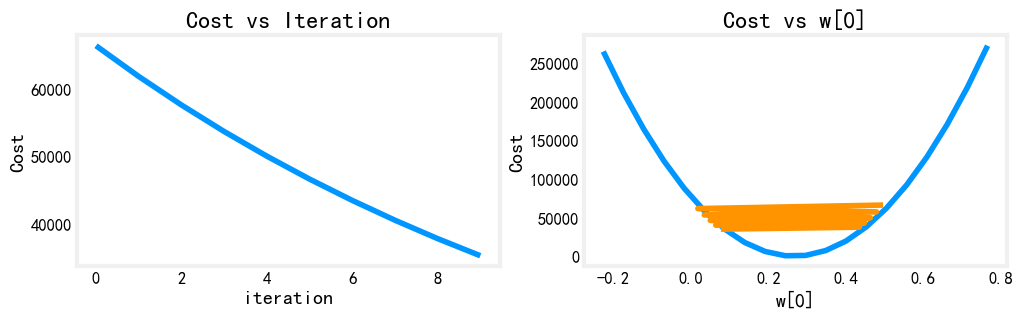

In [9]:
plot_cost_i_w(X_train, y_train, hist)

Cost函数随着迭代次数的增加收敛，但是cost仍在最小值周围震荡，因为`dj_dw[0]`符号在每次迭代都会改变

### $\alpha$ = 1e-7
让我们来尝试更小的值

In [10]:
_,_,hist = run_gradient_descent(X_train, y_train, 10, alpha = 1e-7)

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 4.42313e+04  5.5e-02  1.0e-04  5.2e-05  1.2e-03  3.6e-05 -5.5e+05 -1.0e+03 -5.2e+02 -1.2e+04 -3.6e+02
        1 2.76461e+04  9.8e-02  1.8e-04  9.2e-05  2.2e-03  6.5e-05 -4.3e+05 -7.9e+02 -4.0e+02 -9.5e+03 -2.8e+02
        2 1.75102e+04  1.3e-01  2.4e-04  1.2e-04  2.9e-03  8.7e-05 -3.4e+05 -6.1e+02 -3.1e+02 -7.3e+03 -2.2e+02
        3 1.13157e+04  1.6e-01  2.9e-04  1.5e-04  3.5e-03  1.0e-04 -2.6e+05 -4.8e+02 -2.4e+02 -5.6e+03 -1.8e+02
        4 7.53002e+03  1.8e-01  3.3e-04  1.7e-04  3.9e-03  1.2e-04 -2.1e+05 -3.7e+02 -1.9e+02 -4.2e+03 -1.4e+02
        5 5.21639e+03  2.0e-01  3.5e-04  1.8e-04  4.2e-03  1.3e-04 -1.6e+05 -2.9e+02 -1.5e+02 -3.1e+03 -1.1e+02
        6 3.80242e+03  2.1e-01  3.8e-04  1.9e-04  4.5e-03  1.4e-04 -1.3e+05 -2.2e+02 -1.1e+02 -2.3e+03 -

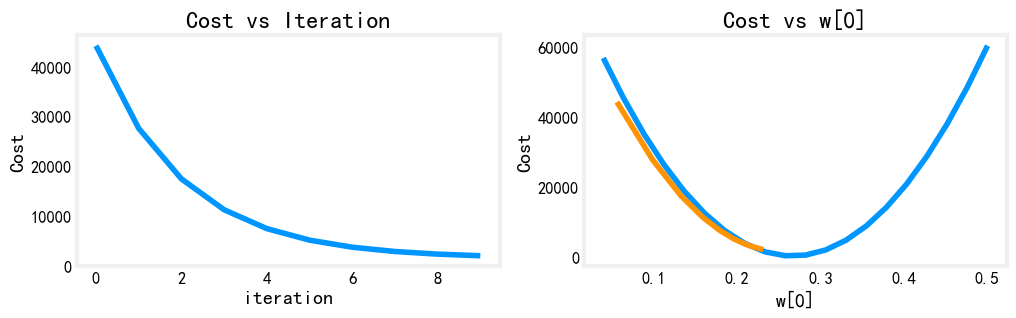

In [11]:
plot_cost_i_w(X_train,y_train,hist)

* Cost函数随着迭代次数的增加收敛，且在不越过最小值的情况下逐步减少


### 对于不同的alpha取值


* 过大的alpha会导致cost值不收敛，甚至发散

* 使得cost收敛的alpha值，并不一定会让cost收敛于最小值，可能会在最小值周围震荡

* 从结果上来看，越小的alpha会让算法越稳定。但是随之而来的就是时间成本和计算成本的增加。

# 2. 通过特征工程扩展到多项式回归
线性回归默认提供了构建以下形式模型的方法：
$$f_{\mathbf{w},b} = w_0x_0 + w_1x_1+ ... + w_{n-1}x_{n-1} + b \tag{1}$$ 
但是大多数情况下，数据集的特征并不会呈线性关系，我们现在拥有的机制是通过梯度下降来找到合适的w、b来拟合数据。但是无论怎么调整都无法实现对非线性曲线的拟合。

## 2.1 $y = 1+x^2$

### 2.1.1 尝试做线性拟合

In [12]:
# 创建目标数据
x = np.arange(0, 20, 1)
y = 1 + x**2
X = x.reshape(-1, 1)
model_w, model_b = run_gradient_descent_feng(X, y, iterations=1000, alpha=1e-2)

Iteration         0, Cost: 1.65756e+03
Iteration       100, Cost: 6.94549e+02
Iteration       200, Cost: 5.88475e+02
Iteration       300, Cost: 5.26414e+02
Iteration       400, Cost: 4.90103e+02
Iteration       500, Cost: 4.68858e+02
Iteration       600, Cost: 4.56428e+02
Iteration       700, Cost: 4.49155e+02
Iteration       800, Cost: 4.44900e+02
Iteration       900, Cost: 4.42411e+02
w,b found by gradient descent: w: [18.7], b: -52.0834


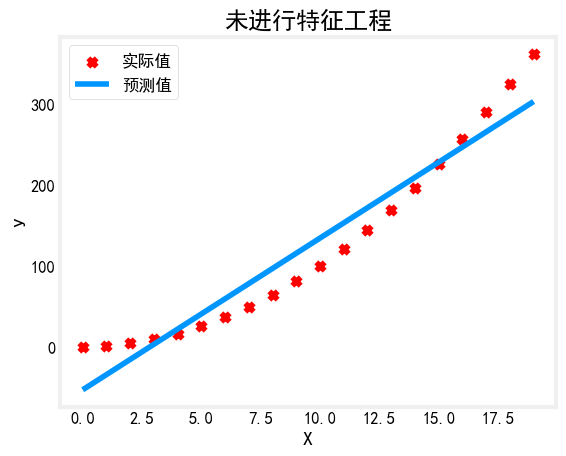

In [13]:
plt.scatter(x, y, marker='x', c='r', label="实际值"); plt.title("未进行特征工程")
plt.plot(x, X@model_w + model_b, label="预测值");  plt.xlabel("X"); plt.ylabel("y"); plt.legend(); plt.show()

正如预期的那样，拟合效果不佳。所需要的是类似于$y= w_0x_0^2 + b$的形式，或者称之为**多项式特征**。为了实现这一点，你可以修改*输入数据*以*工程*所需的特征。如果你用一个平方$x$值的版本替换原始数据，那么你就可以得到$y= w_0x_0^2 + b$。让我们尝试一下。将`X`替换为`X**2`：

### 2.1.2 $X=x^2$作为工程特征

In [14]:
# 创建目标数据
x = np.arange(0, 20, 1)
y = 1 + x**2
# 工程特征 
X = x**2      #<-- 添加工程特征
X = X.reshape(-1, 1)  #X应该是一个二维矩阵
model_w, model_b = run_gradient_descent_feng(X, y, iterations=10000, alpha=1e-5)

Iteration         0, Cost: 7.32922e+03
Iteration      1000, Cost: 2.24844e-01
Iteration      2000, Cost: 2.22795e-01
Iteration      3000, Cost: 2.20764e-01
Iteration      4000, Cost: 2.18752e-01
Iteration      5000, Cost: 2.16758e-01
Iteration      6000, Cost: 2.14782e-01
Iteration      7000, Cost: 2.12824e-01
Iteration      8000, Cost: 2.10884e-01
Iteration      9000, Cost: 2.08962e-01
w,b found by gradient descent: w: [1.], b: 0.0490


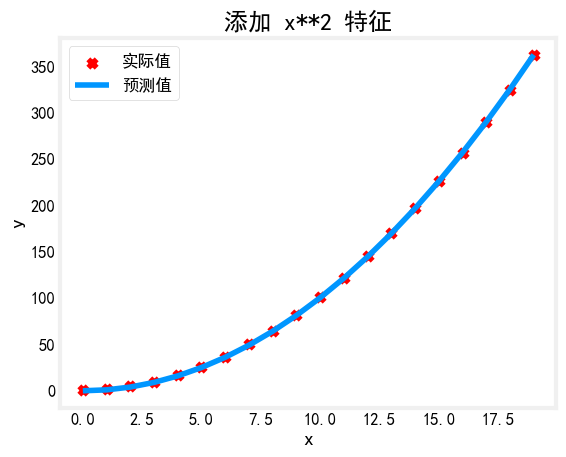

In [15]:
plt.scatter(x, y, marker='x', c='r', label="实际值"); plt.title("添加 x**2 特征")
plt.plot(x, np.dot(X, model_w) + model_b, label="预测值"); plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

完美！通过梯度下降最终得到的 $w: [1.], b: 0.0490$，得到的模型$y=1*x_0^2+0.049$，和目标函数$y=1*x_0^2+1$非常接近

## 2.2 特征选择
在上面的例子中， 我们知道需要一个$x^2$项。但是实际的数据集中，我们并不知道如何添加工程特征。但是从数学的角度上来说，通过泰勒公式我们能将目标函数转换成：
$$
f(x) = f(a) + \frac{f'(a)}{1!}(x - a) + \frac{f''(a)}{2!}(x - a)^2 + \frac{f'''(a)}{3!}(x - a)^3 + \ldots
$$
当a=0时：
$$
f(x) = f(0) + \frac{f'(0)}{1!}x + \frac{f''(0)}{2!}x^2 + \frac{f'''(0)}{3!}x^3 + \ldots
$$


### 2.2.1  特征的探索
从上面的公式不难看出，函数总能写成$y=w_0x_0 + w_1x_1^2 + w_2x_2^3+b$的形式，浅尝一下：

In [16]:
X = np.c_[x, x**2, x**3]   #<-- 添加工程特征
model_w, model_b = run_gradient_descent_feng(X, y, iterations=10000, alpha=1e-7)

Iteration         0, Cost: 1.16186e+03
Iteration      1000, Cost: 3.41850e+02
Iteration      2000, Cost: 2.91813e+02
Iteration      3000, Cost: 2.49102e+02
Iteration      4000, Cost: 2.12644e+02
Iteration      5000, Cost: 1.81524e+02
Iteration      6000, Cost: 1.54959e+02
Iteration      7000, Cost: 1.32284e+02
Iteration      8000, Cost: 1.12928e+02
Iteration      9000, Cost: 9.64059e+01
w,b found by gradient descent: w: [0.08 0.55 0.03], b: 0.0110


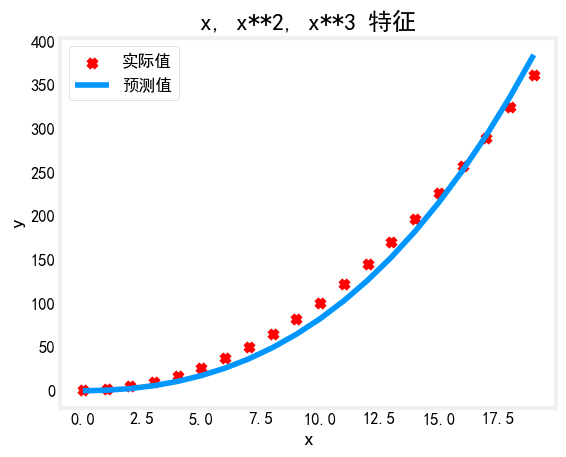

In [17]:
plt.scatter(x, y, marker='x', c='r', label="实际值"); plt.title("x, x**2, x**3 特征")
plt.plot(x, X@model_w + model_b, label="预测值"); plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

注意到w的值，$ w: [0.08 0.55 0.03], b: 0.0110 $ 得到拟合后的模型$ y=0.08x + 0.54x^2 + 0.03x^3 + 0.0106 $可以看到$x^2$的权值明显要大，使用更大的迭代次数，这一现象会更加明显，也就是说梯度下降会帮助我们选择**正确**的特征

#### 让我们再次回顾一下这个想法：
- 首先，特征被重新缩放，以使它们可比较
- 更小的权值意味着更不重要/不正确的特征，而在极端情况下，当权值为零或非常接近零时，相关的特征对拟合数据没有用。
- 在上面的例子中，拟合后，与$x^2$特征相关的权值要比$x$或$x^3$的权值大得多，因为它对拟合数据最有用。

#### 另一种观点
我们创建新特征后，我们仍在使用线性回归，只不过我们的特征从$x$变成了$x,x^2,x^3....$,类似数学中的复合函数的概念

#### 例如

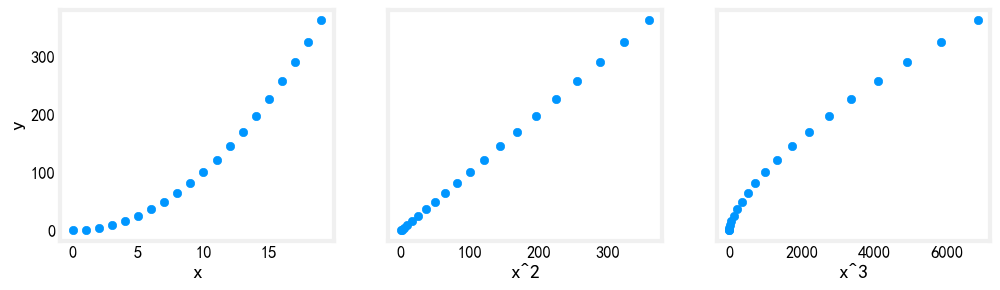

In [18]:
X_features = ['x','x^2','x^3']
fig, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X[:, i], y)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("y")
plt.show()


上面，很明显$x^2$特征与目标值$y$的映射是线性的。因此，一旦创建了这个新特征，线性回归可以很容易地使用它来生成模型。

### 2.2.2 特征缩放
正如上一实验中所述，如果数据集具有显著不同尺度的特征，应该对特征进行缩放以加速梯度下降。在上面的示例中，有$x$、$x^2$和$x^3$，它们自然具有非常不同的尺度。让我们对我们的示例应用Z-score标准化。

In [19]:
print(f"Raw X中每列的峰值到峰值范围:{np.ptp(X,axis=0)}")
# 添加均值标准化 
X = zscore_normalize_features(X)     
print(f"标准化后X中每列的峰值到峰值范围:{np.ptp(X,axis=0)}")

Raw X中每列的峰值到峰值范围:[  19  361 6859]
标准化后X中每列的峰值到峰值范围:[3.3  3.18 3.28]


In [20]:
model_w, model_b = run_gradient_descent_feng(X, y, iterations=100000, alpha=1e-1)

Iteration         0, Cost: 9.52191e+03
Iteration     10000, Cost: 3.90938e-01
Iteration     20000, Cost: 2.78389e-02
Iteration     30000, Cost: 1.98242e-03
Iteration     40000, Cost: 1.41169e-04
Iteration     50000, Cost: 1.00527e-05
Iteration     60000, Cost: 7.15855e-07
Iteration     70000, Cost: 5.09763e-08
Iteration     80000, Cost: 3.63004e-09
Iteration     90000, Cost: 2.58497e-10
w,b found by gradient descent: w: [5.27e-05 1.13e+02 8.43e-05], b: 124.5000


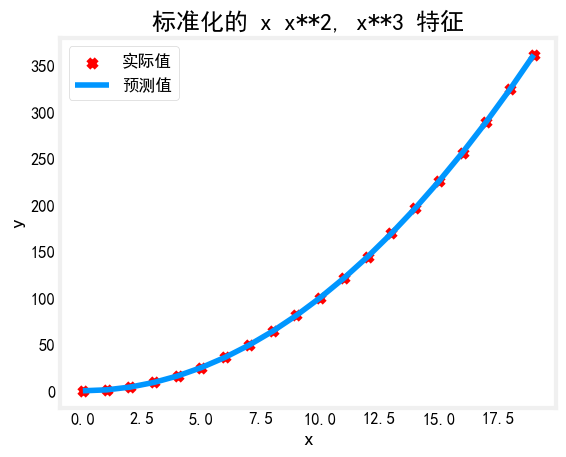

In [21]:
plt.scatter(x, y, marker='x', c='r', label="实际值"); plt.title("标准化的 x x**2, x**3 特征")
plt.plot(x,X@model_w + model_b, label="预测值"); plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

梯度下降的结果$w: [5.27e-05 1.13e+02 8.43e-05], b: 124.5000$，几乎消除了$x,x^3$的影响

## 2.3 拟合复杂函数
这里以$y = cos(x/2)$为例，cosx为周期函数，我们可以以$[-\pi，\pi]$的图像推导整个函数。
麦克劳林级数
$$ 
\cos\left(\frac{x}{2}\right) = 1 - \frac{x^2}{2!2^2} + \frac{x^4}{4!2^4} - \frac{x^6}{6!2^6} + \frac{x^8}{8!2^8} - \ldots
 $$
函数 $y = cos(x/2)$ 在点$ x = a $ 处的泰勒展开式可以表示为：

$$ 
f(x) = f(a) + f'(a)(x - a) + \frac{f''(a)}{2!}(x - a)^2 + \frac{f'''(a)}{3!}(x - a)^3 + \ldots
 $$


并在 \(x = a\) 处展开：

$$ 
\cos\left(\frac{x}{2}\right) = \cos\left(\frac{a}{2}\right) - \frac{1}{2}\sin\left(\frac{a}{2}\right)(x - a) - \frac{1}{4}\cos\left(\frac{a}{2}\right)\frac{(x - a)^2}{2!} + \frac{1}{8}\sin\left(\frac{a}{2}\right)\frac{(x - a)^3}{3!} + \ldots
 $$

#### 不难看出$y = cos(x/2)$可以拟合成关于$x,x^2,x^3,x^4......$的函数

In [22]:
x = np.arange(0,20,1)
y = np.cos(x/2)
X = np.c_[x, x**2, x**3,x**4, x**5, x**6, x**7, x**8, x**9, x**10, x**11, x**12, x**13]
X = zscore_normalize_features(X)
model_w,model_b = run_gradient_descent_feng(X, y, iterations=100000, alpha = 1e-1)

Iteration         0, Cost: 2.24887e-01
Iteration     10000, Cost: 4.26957e-02
Iteration     20000, Cost: 3.32065e-02
Iteration     30000, Cost: 2.92618e-02
Iteration     40000, Cost: 2.73901e-02
Iteration     50000, Cost: 2.63006e-02
Iteration     60000, Cost: 2.55129e-02
Iteration     70000, Cost: 2.48482e-02
Iteration     80000, Cost: 2.42397e-02
Iteration     90000, Cost: 2.36622e-02
w,b found by gradient descent: w: [-4.33e+00  5.90e+00  6.20e+00 -3.32e+00 -7.85e+00 -3.95e+00  6.95e+00
  8.83e-02  5.13e-03  1.94e-02  1.97e-02 -6.81e-02  5.42e-02], b: -0.0073


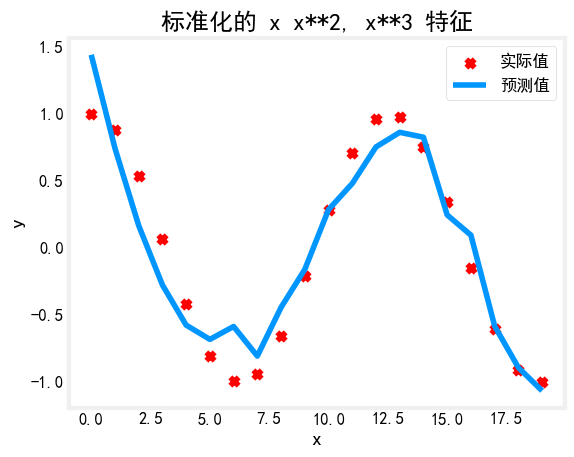

In [23]:
plt.scatter(x, y, marker='x', c='r', label="实际值"); plt.title("标准化的 x x**2, x**3 特征")
plt.plot(x,X@model_w + model_b, label="预测值"); plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.show()

# 3. 使用SKlearn进行房价预测
前面我们实现了梯度下降，损失函数，线性回归，多项式回归，z-socre分数归一化...等一系列算法。下面的部分将使用`scikit-learn`工具包实现对房价预测。

## 3.1 数据导入&归一化

In [24]:
X_train, y_train = load_house_data()
X_features = ['size(sqft)', 'bedrooms', 'floors', 'age']
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
print(f"原始X每列的峰值到峰值范围: {np.ptp(X_train, axis=0)}")
print(f"归一化X每列的峰值到峰值范围: {np.ptp(X_norm, axis=0)}")

原始X每列的峰值到峰值范围: [2.41e+03 4.00e+00 1.00e+00 9.50e+01]
归一化X每列的峰值到峰值范围: [5.85 6.14 2.06 3.69]


## 3.2 创建并拟合回归模型

In [25]:
sgdr = SGDRegressor(max_iter=1000)
sgdr.fit(X_norm, y_train)
print(sgdr)
print(f"完成的迭代次数: {sgdr.n_iter_}, 权重更新次数: {sgdr.t_}")

SGDRegressor()
完成的迭代次数: 123, 权重更新次数: 12178.0


### 3.3 查看参数
使用`SKlearn`进行梯度下降得到的参数和之前得到的数据非常接近

In [26]:
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"模型参数:                   w: {w_norm}, b:{b_norm}")
print("以前实验室的模型参数: w: [110.56 -21.27 -32.71 -37.97], b: 363.16")

模型参数:                   w: [110.12 -21.05 -32.45 -38.05], b:[363.17]
以前实验室的模型参数: w: [110.56 -21.27 -32.71 -37.97], b: 363.16


### 3.4 进行预测

In [27]:
# 使用sgdr.predict()进行预测
y_pred_sgd = sgdr.predict(X_norm)
# 使用w,b进行预测
y_pred = np.dot(X_norm, w_norm) + b_norm
print(f"使用np.dot()和sgdr.predict进行预测是否匹配: {(y_pred == y_pred_sgd).all()}")

print(f"对训练集的预测:\n{y_pred[:4]}")
print(f"目标值 \n{y_train[:4]}")

使用np.dot()和sgdr.predict进行预测是否匹配: True
对训练集的预测:
[295.18 485.91 389.61 492.07]
目标值 
[300.  509.8 394.  540. ]


### 3.5 绘制结果

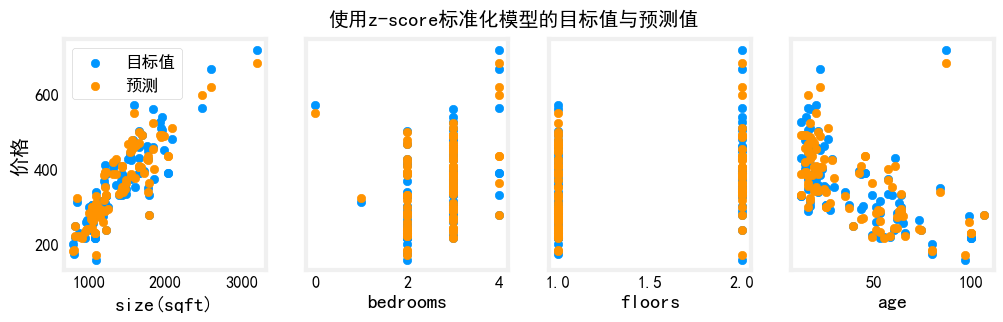

In [28]:
  # 绘制预测和目标值与原始特征的关系  
fig, ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:, i], y_train, label='目标值')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:, i], y_pred, color=dlc["dlorange"], label='预测')
ax[0].set_ylabel("价格")
ax[0].legend()
fig.suptitle("使用z-score标准化模型的目标值与预测值")
plt.show()